## Copmparing Sparse Regularization with Elastic Net with ILC Regularization

### Installations and imports

In [67]:
!pip install -q git+git://github.com/deepmind/optax.git
!pip install -q git+https://github.com/deepmind/dm-haiku

In [68]:
from typing import Any, Generator, Mapping, Tuple

from absl import app
import haiku as hk
import jax
import jax.numpy as jnp
import numpy as np
import optax
import tensorflow_datasets as tfds
from optax._src import transform
from jax import jit, grad, vmap
from jax.tree_util import tree_structure

### AND-mask optax class definition

In [69]:
class ANDMaskState(optax.OptState):
  """Stateless.""" # Following optax code style

def and_mask(agreement_threshold: float) -> optax.GradientTransformation:
  def init_fn(_):
    # Required by optax
    return ANDMaskState()

  def update_fn(updates, opt_state, params=None):

    def and_mask(update):
      # Compute the masked gradients for a single parameter tensor
      mask = jnp.abs(jnp.mean(jnp.sign(update), 0)) >= agreement_threshold
      mask = mask.astype(jnp.float32)
      avg_update = jnp.mean(update, 0)
      mask_t = mask.sum() / mask.size
      update = mask * avg_update * (1. / (1e-10 + mask_t))
      return update

    del params # Following optax code style
    
    # Compute the masked gradients over all parameters

    # jax.tree_map maps a function (lambda function in this case) over a pytree to produce a new pytree.
    updates = jax.tree_map(lambda x: and_mask(x), updates)
    return updates, opt_state

  return transform.GradientTransformation(init_fn, update_fn)

### MNIST Classification: Layers:(input, 500, 500, 10), (Optional) Regularizer: Yes, ILC: Yes

In [ ]:
"""MNIST classifier example."""


OptState = Any
Batch = Mapping[str, np.ndarray]


def net_fn(batch) -> jnp.ndarray:
  
  x = jnp.array(batch, jnp.float32) / 255.
  mlp = hk.Sequential([
      hk.Flatten(),
      hk.Linear(500), jax.nn.relu, # 300
      hk.Linear(500), jax.nn.relu, # 1000
      hk.Linear(10),
  ])
  return mlp(x)


def load_dataset(
    split: str,
    *,
    is_training: bool,
    batch_size: int,
    ) -> Generator[Batch, None, None]:
    """Loads the dataset as a generator of batches."""
    ds = tfds.load("mnist:3.*.*", split=split).cache().repeat()
    if is_training:
        ds = ds.shuffle(10 * batch_size, seed=0)
    ds = ds.batch(batch_size)
    return iter(tfds.as_numpy(ds))


# Make the network and optimiser.
net = hk.without_apply_rng(hk.transform(net_fn))
# opt = optax.adam(1e-3)
agreement_threshold = 0.8
opt = optax.chain(and_mask(agreement_threshold),optax.adam(1e-3)
    # ,optax.scale_by_adam()
    )

    
  # Training loss (cross-entropy).
def loss(params: hk.Params, batch, label) -> jnp.ndarray:
    """Compute the loss of the network, including L2."""
    logits = net.apply(params, batch)
    labels = jax.nn.one_hot(label, 10)

    # L1 Loss
    sum_in_layer = lambda p: jnp.sum(p)
    sum_p_layers = [sum_in_layer(p) for p in jax.tree_leaves(params)]
    l1_loss = sum(sum_p_layers)

    # L2 Loss
    l2_loss = 0.5 * sum(jnp.sum(jnp.square(p)) for p in jax.tree_leaves(params))

    # Cross Entropy Loss
    softmax_xent = -jnp.sum(labels * jax.nn.log_softmax(logits))
    softmax_xent /= labels.shape[0]
    return softmax_xent + 1e-4 * l2_loss + 1e-5 * l1_loss

@jax.jit
def gradient_per_sample(params, batch, label):
    batch, label = jnp.expand_dims(batch,1), jnp.expand_dims(label,1)
    return vmap(grad(loss), in_axes=(None, 0, 0))(params, batch, label)


# Evaluation metric (classification accuracy).
@jax.jit
def accuracy(params: hk.Params, batch, label) -> jnp.ndarray:
    predictions = net.apply(params, batch)
    return jnp.mean(jnp.argmax(predictions, axis=-1) == label)

@jax.jit
def update(
      params: hk.Params,
      opt_state: OptState,
      batch, label
    ) -> Tuple[hk.Params, OptState]:
    """Learning rule (stochastic gradient descent)."""
    # grads = jax.grad(loss)(params, batch, label)
    grads = (gradient_per_sample)(params, batch, label)
    updates, opt_state = opt.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, opt_state

# We maintain avg_params, the exponential moving average of the "live" params.
# avg_params is used only for evaluation.
# For more, see: https://doi.org/10.1137/0330046
@jax.jit
def ema_update(
      avg_params: hk.Params,
      new_params: hk.Params,
      epsilon: float = 0.001,
  ) -> hk.Params:
    return jax.tree_multimap(lambda p1, p2: (1 - epsilon) * p1 + epsilon * p2,
                             avg_params, new_params)

# Make datasets.
train = load_dataset("train", is_training=True, batch_size=1000)
train_eval = load_dataset("train", is_training=False, batch_size=10000)
test_eval = load_dataset("test", is_training=False, batch_size=10000)

# Initialize network and optimiser; note we draw an input to get shapes.
params = avg_params = net.init(jax.random.PRNGKey(42), next(train)['image'])
opt_state = opt.init(params)

# print(jax.grad(loss)(params, next(train)))

# Train/eval loop.
for step in range(10001):
    if step % 1000 == 0:
      # Periodically evaluate classification accuracy on train & test sets.
      Batch = next(train_eval)
      train_accuracy = accuracy(avg_params, Batch['image'], Batch['label'])
      Batch = next(test_eval)
      test_accuracy = accuracy(avg_params, Batch['image'], Batch['label'])
      train_accuracy, test_accuracy = jax.device_get(
          (train_accuracy, test_accuracy))
      print(f"[Step {step}] Train / Test accuracy: "
            f"{train_accuracy:.3f} / {test_accuracy:.3f}.")

    # Do SGD on a batch of training examples.

    Batch = next(train)
    params, opt_state = update(params, opt_state, Batch['image'], Batch['label'])
    avg_params = ema_update(avg_params, params)

### Sparse Logistic Regression with MNIST (Only the NN architecture differs from the above cell)

In [ ]:
"""MNIST classifier example."""


OptState = Any
Batch = Mapping[str, np.ndarray]


def net_fn(batch) -> jnp.ndarray:
  
  x = jnp.array(batch, jnp.float32) / 255.
  mlp = hk.Sequential([
      hk.Flatten(),
      hk.Linear(10),
  ])
  return mlp(x)


def load_dataset(
    split: str,
    *,
    is_training: bool,
    batch_size: int,
    ) -> Generator[Batch, None, None]:
    """Loads the dataset as a generator of batches."""
    ds = tfds.load("mnist:3.*.*", split=split).cache().repeat()
    if is_training:
        ds = ds.shuffle(10 * batch_size, seed=0)
    ds = ds.batch(batch_size)
    return iter(tfds.as_numpy(ds))


# Make the network and optimiser.
net = hk.without_apply_rng(hk.transform(net_fn))
# opt = optax.adam(1e-3)
agreement_threshold = 0.7
use_ilc = True
opt = optax.chain(and_mask(agreement_threshold),optax.adam(1e-3)
    # ,optax.scale_by_adam()
    )

    
  # Training loss (cross-entropy).
def loss(params: hk.Params, batch, label) -> jnp.ndarray:
    """Compute the loss of the network, including L2."""
    logits = net.apply(params, batch)
    labels = jax.nn.one_hot(label, 10)

    # L1 Loss
    sum_in_layer = lambda p: jnp.sum(p)
    sum_p_layers = [sum_in_layer(p) for p in jax.tree_leaves(params)]
    l1_loss = sum(sum_p_layers)

    # L2 Loss
    l2_loss = 0.5 * sum(jnp.sum(jnp.square(p)) for p in jax.tree_leaves(params))

    # Cross Entropy Loss
    softmax_xent = -jnp.sum(labels * jax.nn.log_softmax(logits))
    softmax_xent /= labels.shape[0]
    return softmax_xent + 1e-4 * l2_loss + 1e-5 * l1_loss

@jax.jit
def gradient_per_sample(params, batch, label):
    batch, label = jnp.expand_dims(batch,1), jnp.expand_dims(label,1)
    return vmap(grad(loss), in_axes=(None, 0, 0))(params, batch, label)

gradient = jax.jit(grad(loss))

# Evaluation metric (classification accuracy).
@jax.jit
def accuracy(params: hk.Params, batch, label) -> jnp.ndarray:
    predictions = net.apply(params, batch)
    return jnp.mean(jnp.argmax(predictions, axis=-1) == label)

@jax.jit
def update(
      params: hk.Params,
      opt_state: OptState,
      batch, label
    ) -> Tuple[hk.Params, OptState]:
    """Learning rule (stochastic gradient descent)."""
    # grads = jax.grad(loss)(params, batch, label)
    grads = (gradient_per_sample if use_ilc else gradient)(params, batch, label)
    updates, opt_state = opt.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, opt_state

# We maintain avg_params, the exponential moving average of the "live" params.
# avg_params is used only for evaluation.
# For more, see: https://doi.org/10.1137/0330046
@jax.jit
def ema_update(
      avg_params: hk.Params,
      new_params: hk.Params,
      epsilon: float = 0.001,
  ) -> hk.Params:
    return jax.tree_multimap(lambda p1, p2: (1 - epsilon) * p1 + epsilon * p2,
                             avg_params, new_params)

# Make datasets.
train = load_dataset("train", is_training=True, batch_size=1000)
train_eval = load_dataset("train", is_training=False, batch_size=10000)
test_eval = load_dataset("test", is_training=False, batch_size=10000)

# Initialize network and optimiser; note we draw an input to get shapes.
params = avg_params = net.init(jax.random.PRNGKey(42), next(train)['image'])
opt_state = opt.init(params)

# print(jax.grad(loss)(params, next(train)))

# Train/eval loop.
for step in range(10001):
    if step % 1000 == 0:
      # Periodically evaluate classification accuracy on train & test sets.
      Batch = next(train_eval)
      train_accuracy = accuracy(avg_params, Batch['image'], Batch['label'])
      Batch = next(test_eval)
      test_accuracy = accuracy(avg_params, Batch['image'], Batch['label'])
      train_accuracy, test_accuracy = jax.device_get(
          (train_accuracy, test_accuracy))
      print(f"[Step {step}] Train / Test accuracy: "
            f"{train_accuracy:.3f} / {test_accuracy:.3f}.")

    # Do SGD on a batch of training examples.

    Batch = next(train)
    params, opt_state = update(params, opt_state, Batch['image'], Batch['label'])

    avg_params = ema_update(avg_params, params)

### Sparse Logistic Regression Function (For reusability)

In [85]:
OptState = Any
Batch = Mapping[str, np.ndarray]

def sparse_logistic_regression(train, adam_lr=1e-3, agreement_threshold=0.0,
                               use_ilc=False, l1_coef=1e-5, l2_coef=1e-4,
                               epochs=10001, Verbose=False):



    def net_fn(batch) -> jnp.ndarray:
    
        x = jnp.array(batch, jnp.float32) / 255.
        mlp = hk.Sequential([
            hk.Flatten(),
            hk.Linear(10),
        ])
        return mlp(x)


    # Make the network and optimiser.
    net = hk.without_apply_rng(hk.transform(net_fn))

    use_ilc = True
    opt = optax.chain(and_mask(agreement_threshold),optax.adam(adam_lr)
        # ,optax.scale_by_adam()
        )

    
    # Training loss (cross-entropy).
    def loss(params: hk.Params, batch, label) -> jnp.ndarray:
        """Compute the loss of the network, including L1, and L2."""
        logits = net.apply(params, batch)
        labels = jax.nn.one_hot(label, 10)

        # L1 Loss
        sum_in_layer = lambda p: jnp.sum(p)
        sum_p_layers = [sum_in_layer(p) for p in jax.tree_leaves(params)]
        l1_loss = sum(sum_p_layers)

        # L2 Loss
        l2_loss = 0.5 * sum(jnp.sum(jnp.square(p)) for p in jax.tree_leaves(params))

        # Cross Entropy Loss
        softmax_xent = -jnp.sum(labels * jax.nn.log_softmax(logits))
        softmax_xent /= labels.shape[0]
        return softmax_xent + l2_coef * l2_loss + l1_coef * l1_loss

    @jax.jit
    def gradient_per_sample(params, batch, label):
        batch, label = jnp.expand_dims(batch,1), jnp.expand_dims(label,1)
        return vmap(grad(loss), in_axes=(None, 0, 0))(params, batch, label)

    gradient = jax.jit(grad(loss))

    # Evaluation metric (classification accuracy).
    @jax.jit
    def accuracy(params: hk.Params, batch, label) -> jnp.ndarray:
        predictions = net.apply(params, batch)
        return jnp.mean(jnp.argmax(predictions, axis=-1) == label)

    @jax.jit
    def update(
        params: hk.Params,
        opt_state: OptState,
        batch, label
        ) -> Tuple[hk.Params, OptState]:
        """Learning rule (stochastic gradient descent)."""
        # grads = jax.grad(loss)(params, batch, label)
        grads = (gradient_per_sample if use_ilc else gradient)(params, batch, label)
        updates, opt_state = opt.update(grads, opt_state)
        new_params = optax.apply_updates(params, updates)
        return new_params, opt_state

    # We maintain avg_params, the exponential moving average of the "live" params.
    # avg_params is used only for evaluation.
    # For more, see: https://doi.org/10.1137/0330046
    @jax.jit
    def ema_update(
        avg_params: hk.Params,
        new_params: hk.Params,
        epsilon: float = 0.001,
    ) -> hk.Params:
        return jax.tree_multimap(lambda p1, p2: (1 - epsilon) * p1 + epsilon * p2,
                                avg_params, new_params)


    # Initialize network and optimiser; note we draw an input to get shapes.
    params = avg_params = net.init(jax.random.PRNGKey(42), next(train)['image'])
    opt_state = opt.init(params)


    # Train/eval loop.
    for step in range(epochs):
        if step % np.int(epochs/10) == 0:
            # Periodically evaluate classification accuracy on train & test sets.
            Batch = next(train)
            train_accuracy = accuracy(avg_params, Batch['image'], Batch['label'])
            train_accuracy = jax.device_get(train_accuracy)
            if Verbose:
                print(f"[Step {step}] Train accuracy: "
                        f"{train_accuracy:.3f}.")

        # Do SGD on a batch of training examples.
        Batch = next(train)
        params, opt_state = update(params, opt_state, Batch['image'], Batch['label'])
        avg_params = ema_update(avg_params, params)
    
    return params

### If you want to get the results for a single environment, use these cells with whatever regularization (l1,l2,ilc)

In [61]:
avg_params = logistic_sparse_regression(train, adam_lr=1e-3, agreement_threshold=0.0,
                               use_ilc=False, l1_coef=1e-5, l2_coef=1e-4,
                               epochs=10001, Verbose=True)

[Step 0] Train accuracy: 0.063.
[Step 1000] Train accuracy: 0.907.
[Step 2000] Train accuracy: 0.919.
[Step 3000] Train accuracy: 0.927.
[Step 4000] Train accuracy: 0.929.
[Step 5000] Train accuracy: 0.933.
[Step 6000] Train accuracy: 0.932.
[Step 7000] Train accuracy: 0.932.
[Step 8000] Train accuracy: 0.929.
[Step 9000] Train accuracy: 0.934.
[Step 10000] Train accuracy: 0.934.


(784, 10)


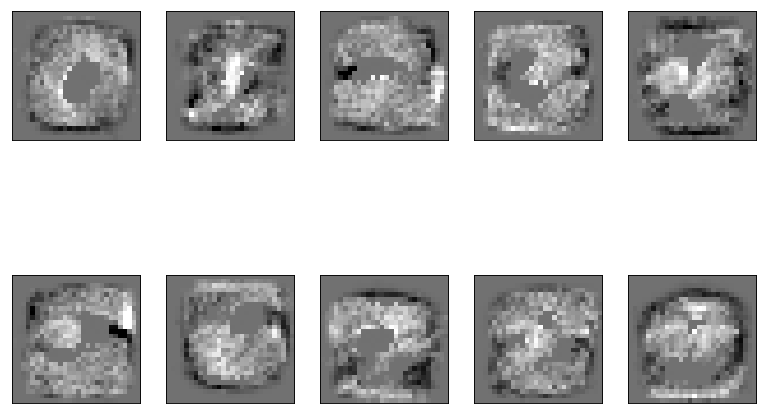

In [26]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

print(avg_params['linear']['w'].shape)
fig, axes = plt.subplots(2, 5, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
# use global min / max to ensure all weights are shown on the same scale
vmin, vmax = avg_params['linear']['w'].min(), avg_params['linear']['w'].max()
for coef, ax in zip(avg_params['linear']['w'].T, axes.ravel()):
    ax.matshow(coef.reshape(28, 28), cmap=plt.cm.gray, vmin=.5 * vmin,
               vmax=.5 * vmax)
    ax.set_xticks(())
    ax.set_yticks(())

plt.show()

### Use this cell to train on n_envs number of environments with elastic net regularizer but no ilc (you can change it to include ilc as well)

In [ ]:
n_envs = 4
ds_train_envs = []
batch_size = 1000
splits = tfds.even_splits('train', n=n_envs)
for m in range(n_envs):
    ds = tfds.load("mnist:3.*.*", split=splits[m]).cache().repeat()
    ds = ds.shuffle(10 * batch_size, seed=0)
    ds = ds.batch(batch_size)
    ds_train_envs.append(iter(tfds.as_numpy(ds)))

envs_elastic_net_params = []
for m in range(n_envs):
    params = logistic_sparse_regression(ds_train_envs[m], adam_lr=1e-3, agreement_threshold=0.0,
                               use_ilc=False, l1_coef=1e-4, l2_coef=1e-5,
                               epochs=10001, Verbose=True)
    envs_elastic_net_params.append(params)

### Use this cell to train on n_envs number of environments with ilc but not elastic net regularizer (you can change it to include ilc as well)

In [ ]:
n_envs = 4
ds_train_envs = []
batch_size = 1000
splits = tfds.even_splits('train', n=n_envs)
for m in range(n_envs):
    ds = tfds.load("mnist:3.*.*", split=splits[m]).cache().repeat()
    ds = ds.shuffle(10 * batch_size, seed=0)
    ds = ds.batch(batch_size)
    ds_train_envs.append(iter(tfds.as_numpy(ds)))

envs_ilc_params = []
for m in range(n_envs):
    params = logistic_sparse_regression(ds_train_envs[m], adam_lr=1e-3, agreement_threshold=0.3,
                               use_ilc=True, l1_coef=0., l2_coef=0.,
                               epochs=10001, Verbose=True)
    envs_ilc_params.append(params)

### Sicne we want to explore resulting weights for various hyperparameters, it'd be better to store them with a proper name to be plotted later. Change the name when you store a parameter according to the regularizers and their value.

In [141]:
import pickle
root_dir = '/content/drive/MyDrive/Mila Fall 2020/Probabilistic Graphical Models/Project/Data/'

def storeData(object, file_name, root_dir):
    with open(root_dir+file_name, 'wb') as f:
        pickle.dump(object, f)					 
        f.close() 

def loadData(file_name, root_dir): 
    with open(root_dir+file_name, 'rb') as f:
        db = pickle.load(f) 
        f.close()
        return db

# storeData(envs_elastic_net_params, 'envs_elastic_net_params', root_dir)
# storeData(envs_ilc_params, 'envs_ilc_params', root_dir)


# envs_elastic_net_params = loadData('envs_elastic_net_params_l14_l25', root_dir)
envs_ilc_params = loadData('envs_ilc_params_agth_09', root_dir)

### Elastic Net without ILC `L1_coef=1e-*3*, L2_coef=1e-5`

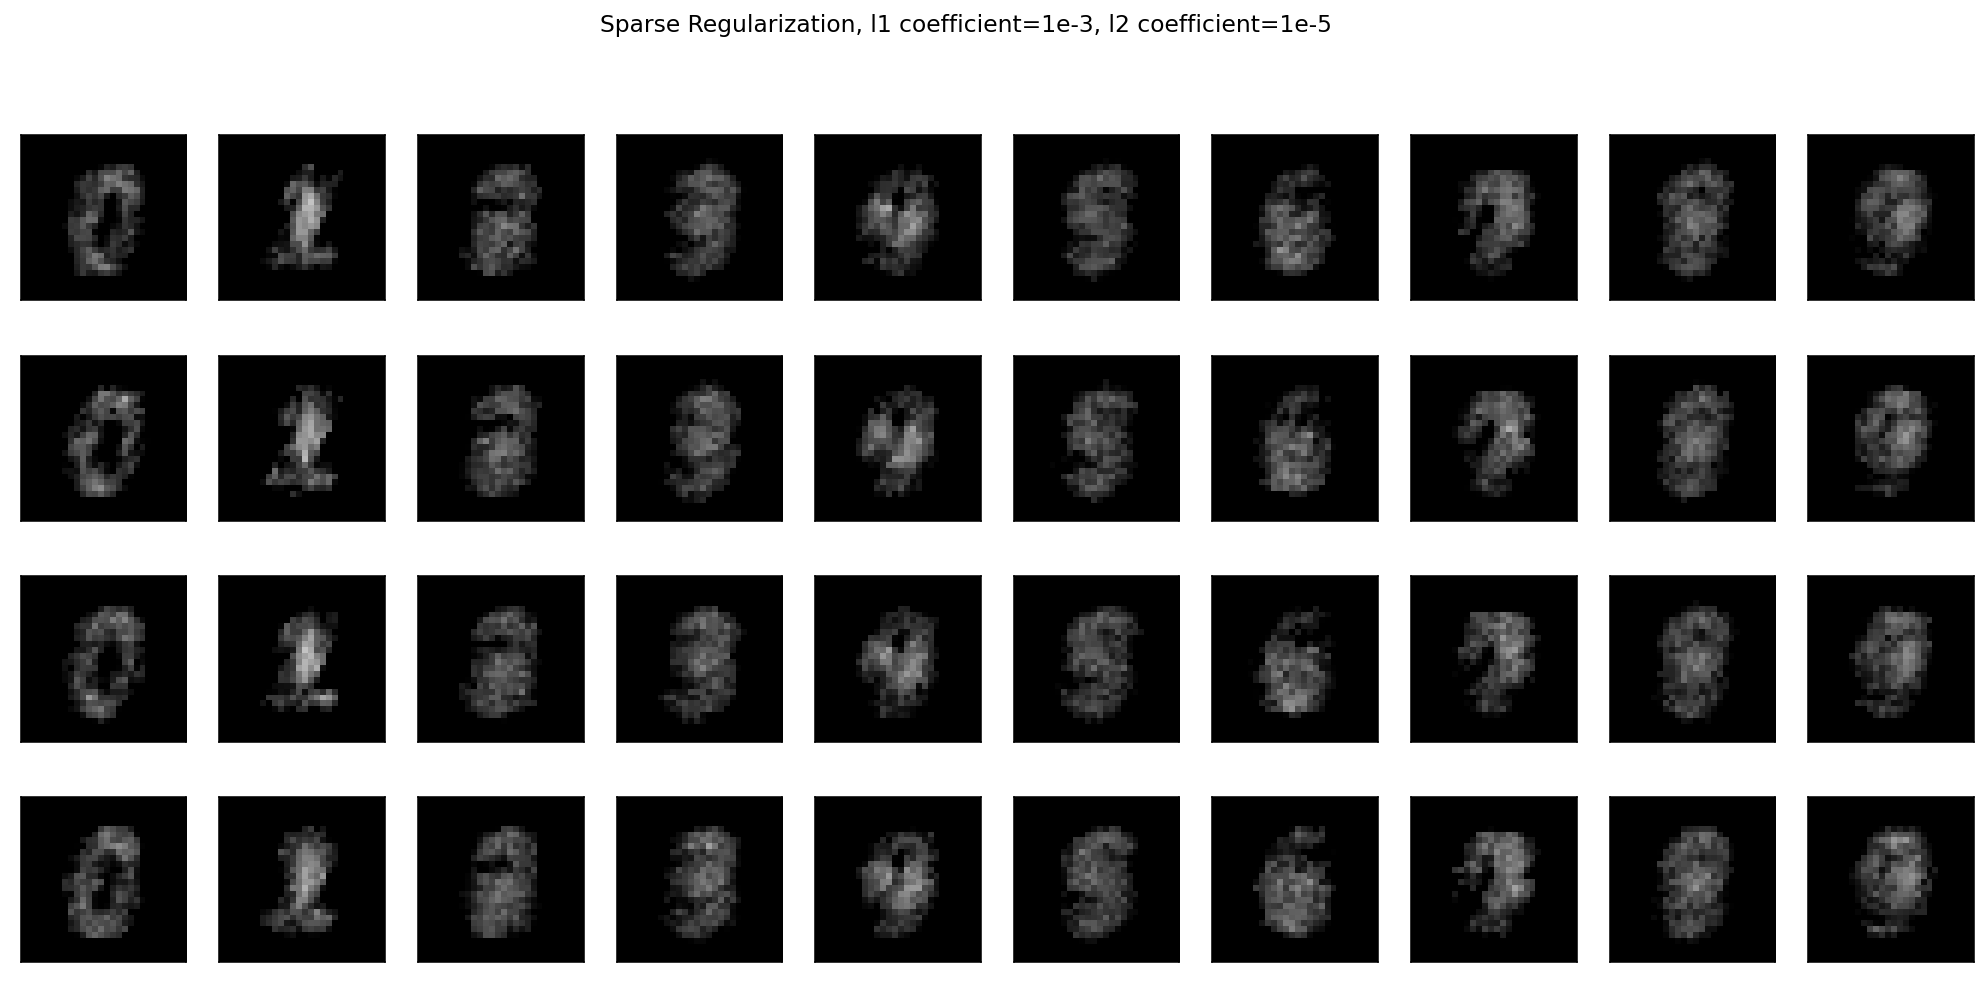

In [134]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

fig, axes = plt.subplots(4, 10, figsize=(18, 8), dpi=140, facecolor='w', edgecolor='k')
# use global min / max to ensure all weights are shown on the same scale
for m in range(n_envs):
    vmin, vmax = envs_elastic_net_params[m]['linear']['w'].min(), envs_elastic_net_params[m]['linear']['w'].max()
    for coef, ax in zip(envs_elastic_net_params[m]['linear']['w'].T, axes[m,:]):
        ax.matshow(coef.reshape(28, 28), cmap=plt.cm.gray, vmin=.5 * vmin,
                vmax=.5 * vmax)
        ax.set_xticks(())
        ax.set_yticks(())

plt.suptitle('Sparse Regularization, l1 coefficient=1e-3, l2 coefficient=1e-5')
plt.show()

### Elastic Net without ILC `L1_coef=1e-4, L2_coef=1e-5`

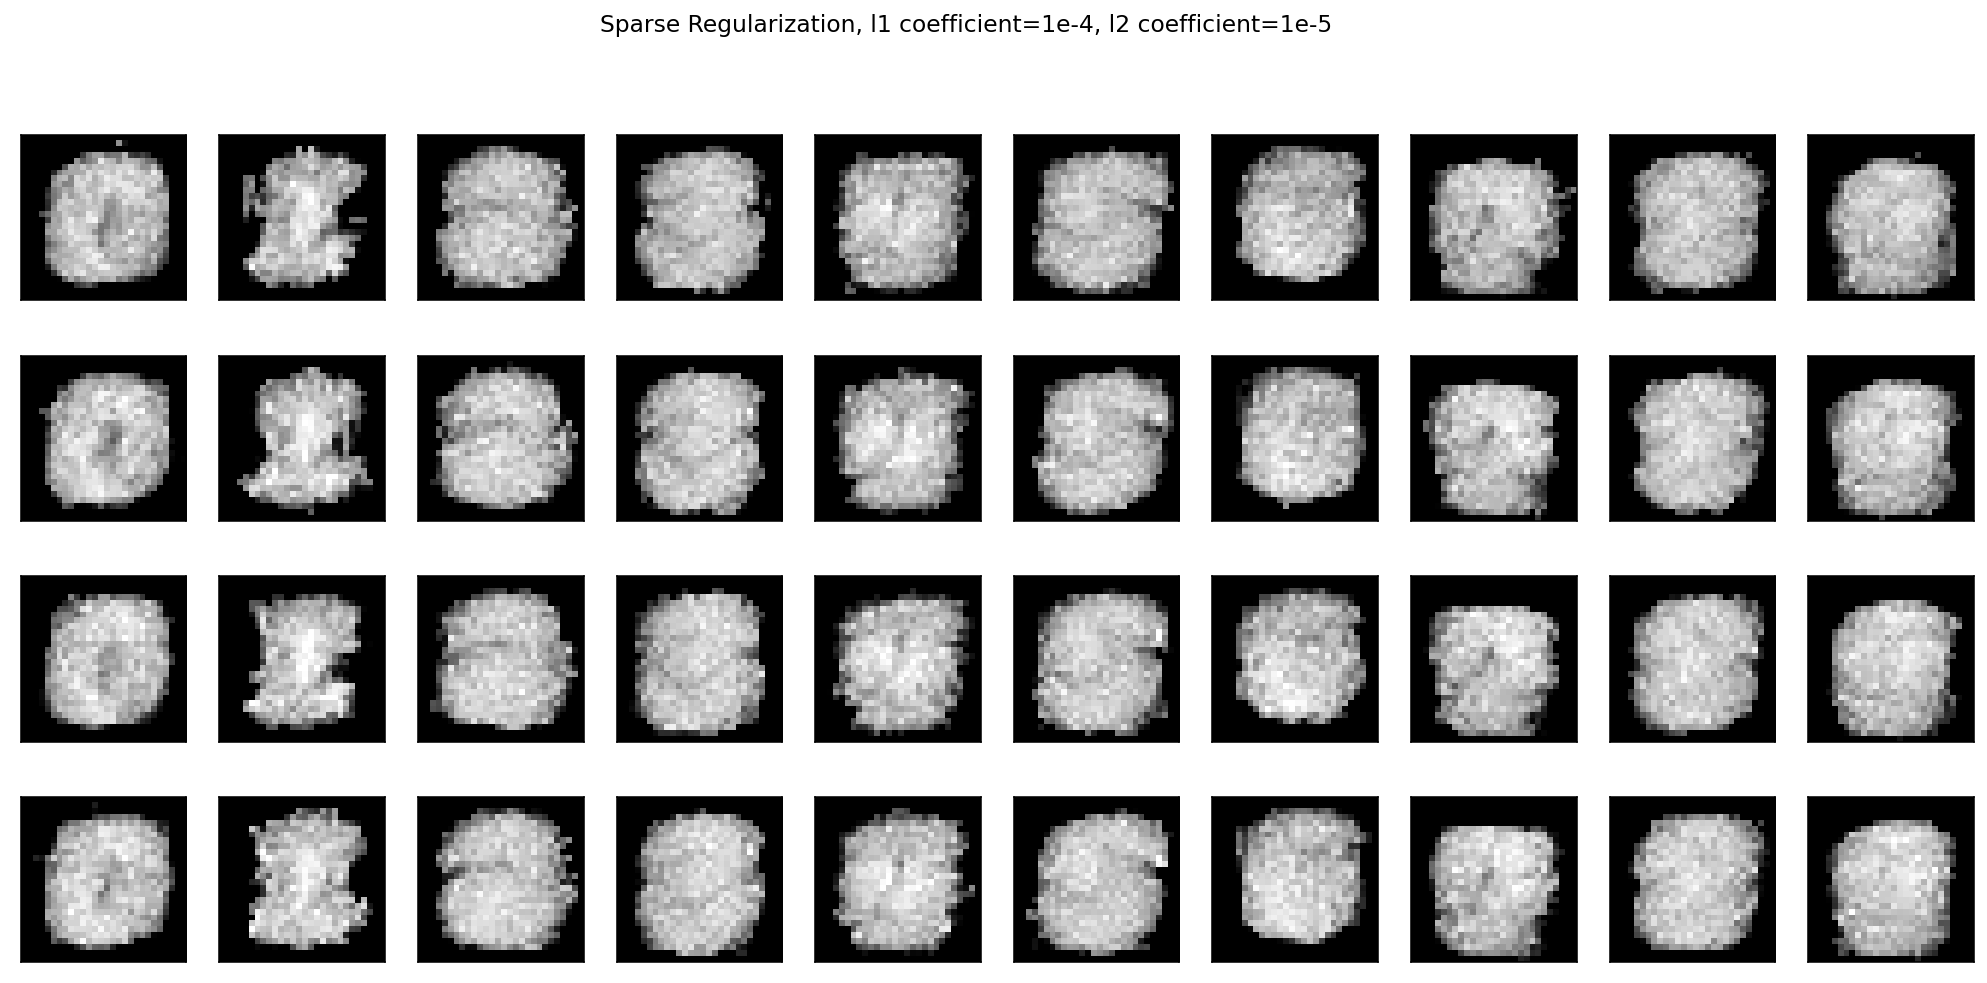

In [127]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

fig, axes = plt.subplots(4, 10, figsize=(18, 8), dpi=130, facecolor='w', edgecolor='k')
# use global min / max to ensure all weights are shown on the same scale
for m in range(n_envs):
    vmin, vmax = envs_elastic_net_params[m]['linear']['w'].min(), envs_elastic_net_params[m]['linear']['w'].max()
    for coef, ax in zip(envs_elastic_net_params[m]['linear']['w'].T, axes[m,:]):
        ax.matshow(coef.reshape(28, 28), cmap=plt.cm.gray, vmin=.5 * vmin,
                vmax=.5 * vmax)
        ax.set_xticks(())
        ax.set_yticks(())

plt.suptitle('Sparse Regularization, l1 coefficient=1e-4, l2 coefficient=1e-5')
plt.show()

### Elastic Net without ILC `L1_coef=1e-*5*, L2_coef=1e-5`

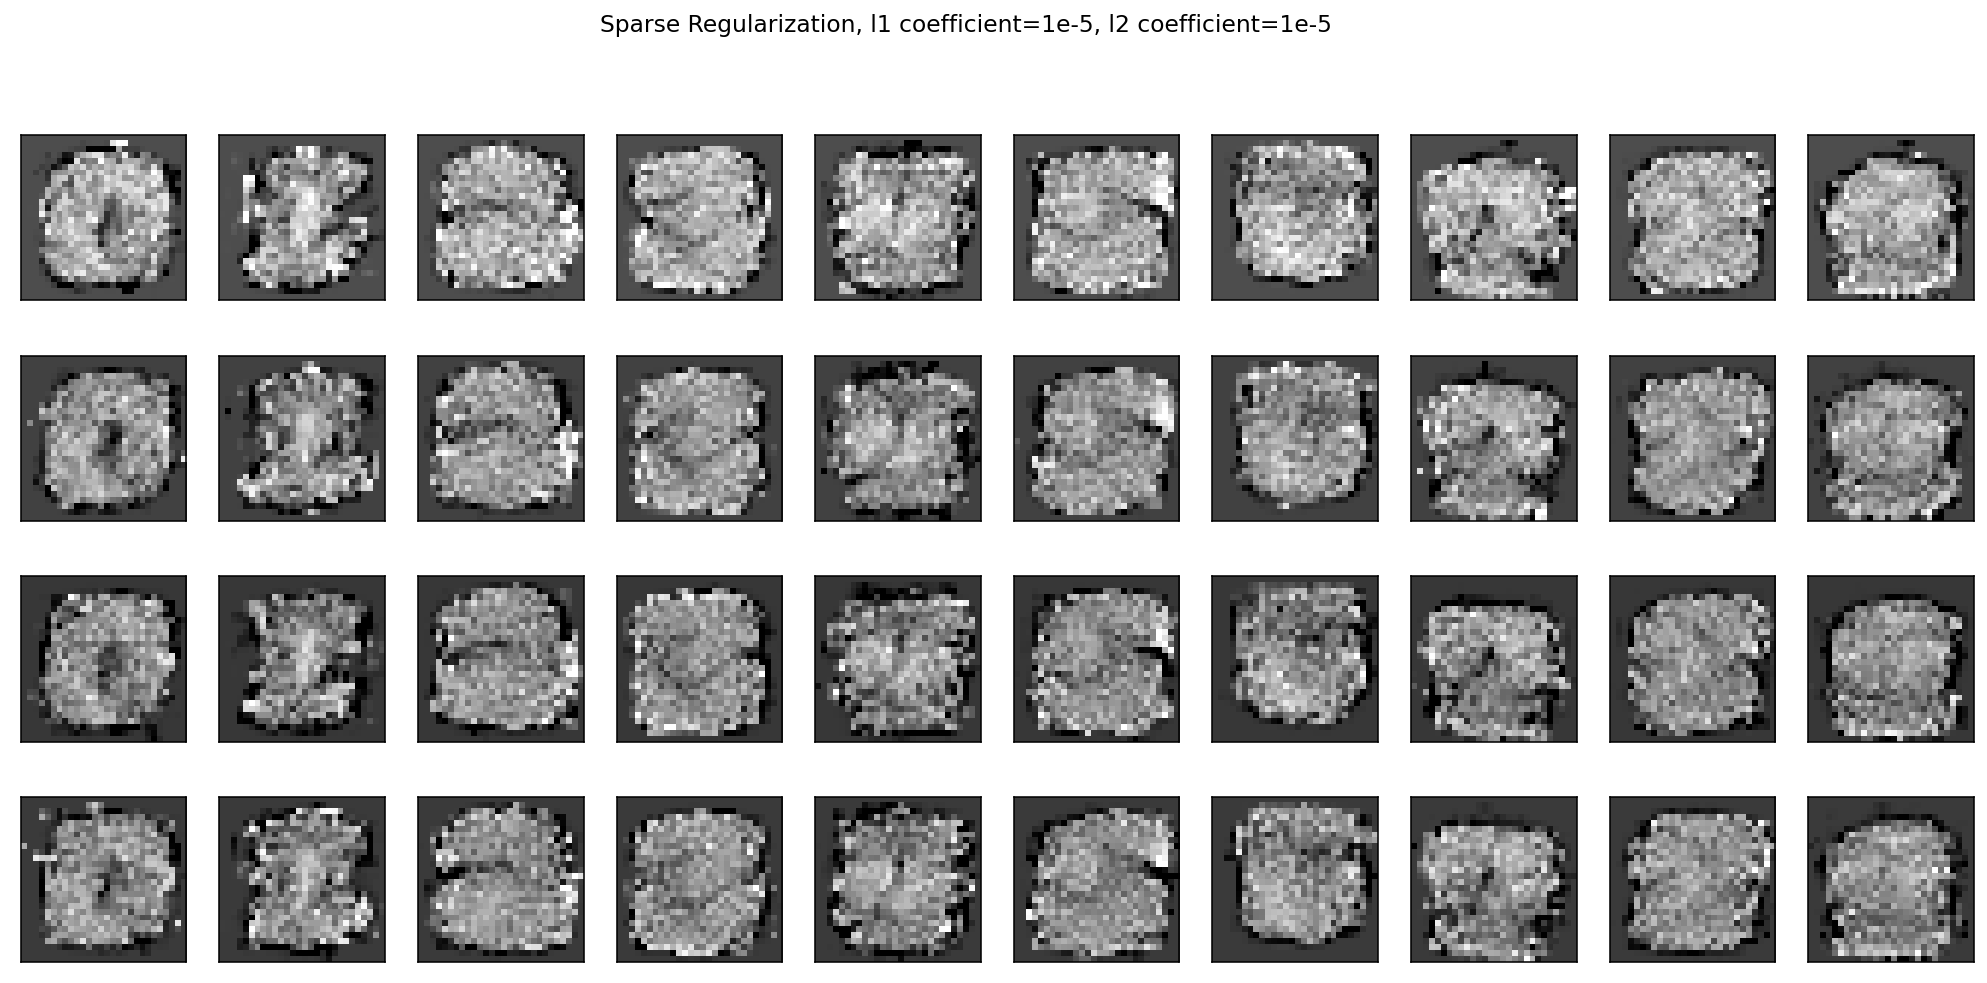

In [132]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

fig, axes = plt.subplots(4, 10, figsize=(18, 8), dpi=140, facecolor='w', edgecolor='k')
# use global min / max to ensure all weights are shown on the same scale
for m in range(n_envs):
    vmin, vmax = envs_elastic_net_params[m]['linear']['w'].min(), envs_elastic_net_params[m]['linear']['w'].max()
    for coef, ax in zip(envs_elastic_net_params[m]['linear']['w'].T, axes[m,:]):
        ax.matshow(coef.reshape(28, 28), cmap=plt.cm.gray, vmin=.5 * vmin,
                vmax=.5 * vmax)
        ax.set_xticks(())
        ax.set_yticks(())

plt.suptitle('Sparse Regularization, l1 coefficient=1e-5, l2 coefficient=1e-5')
plt.show()

### Agreement Threshold = 0.1

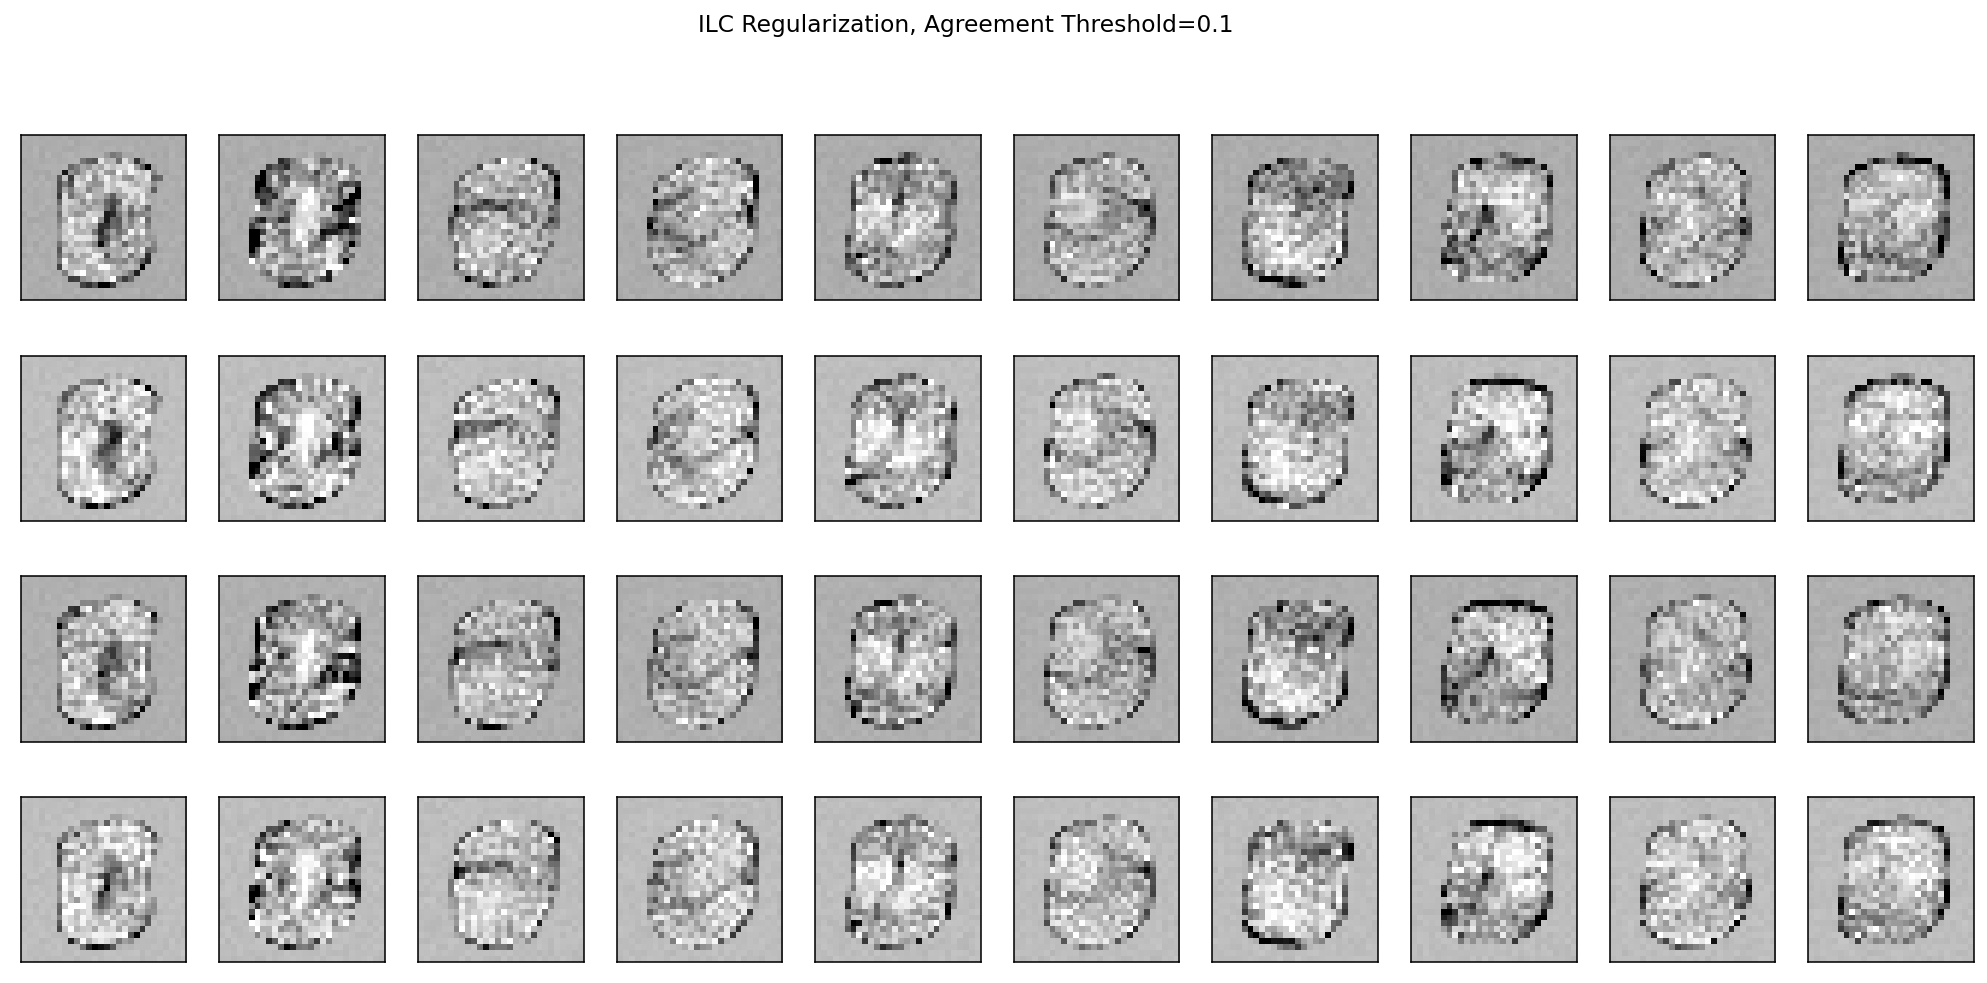

In [137]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

fig, axes = plt.subplots(4, 10, figsize=(18, 8), dpi=140, facecolor='w', edgecolor='k')
# use global min / max to ensure all weights are shown on the same scale
for m in range(n_envs):
    vmin, vmax = envs_ilc_params[m]['linear']['w'].min(), envs_ilc_params[m]['linear']['w'].max()
    for coef, ax in zip(envs_ilc_params[m]['linear']['w'].T, axes[m,:]):
        ax.matshow(coef.reshape(28, 28), cmap=plt.cm.gray, vmin=.5 * vmin,
                vmax=.5 * vmax)
        ax.set_xticks(())
        ax.set_yticks(())

plt.suptitle('ILC Regularization, Agreement Threshold=0.1')
plt.show()

### Agreement Threshold = 0.3

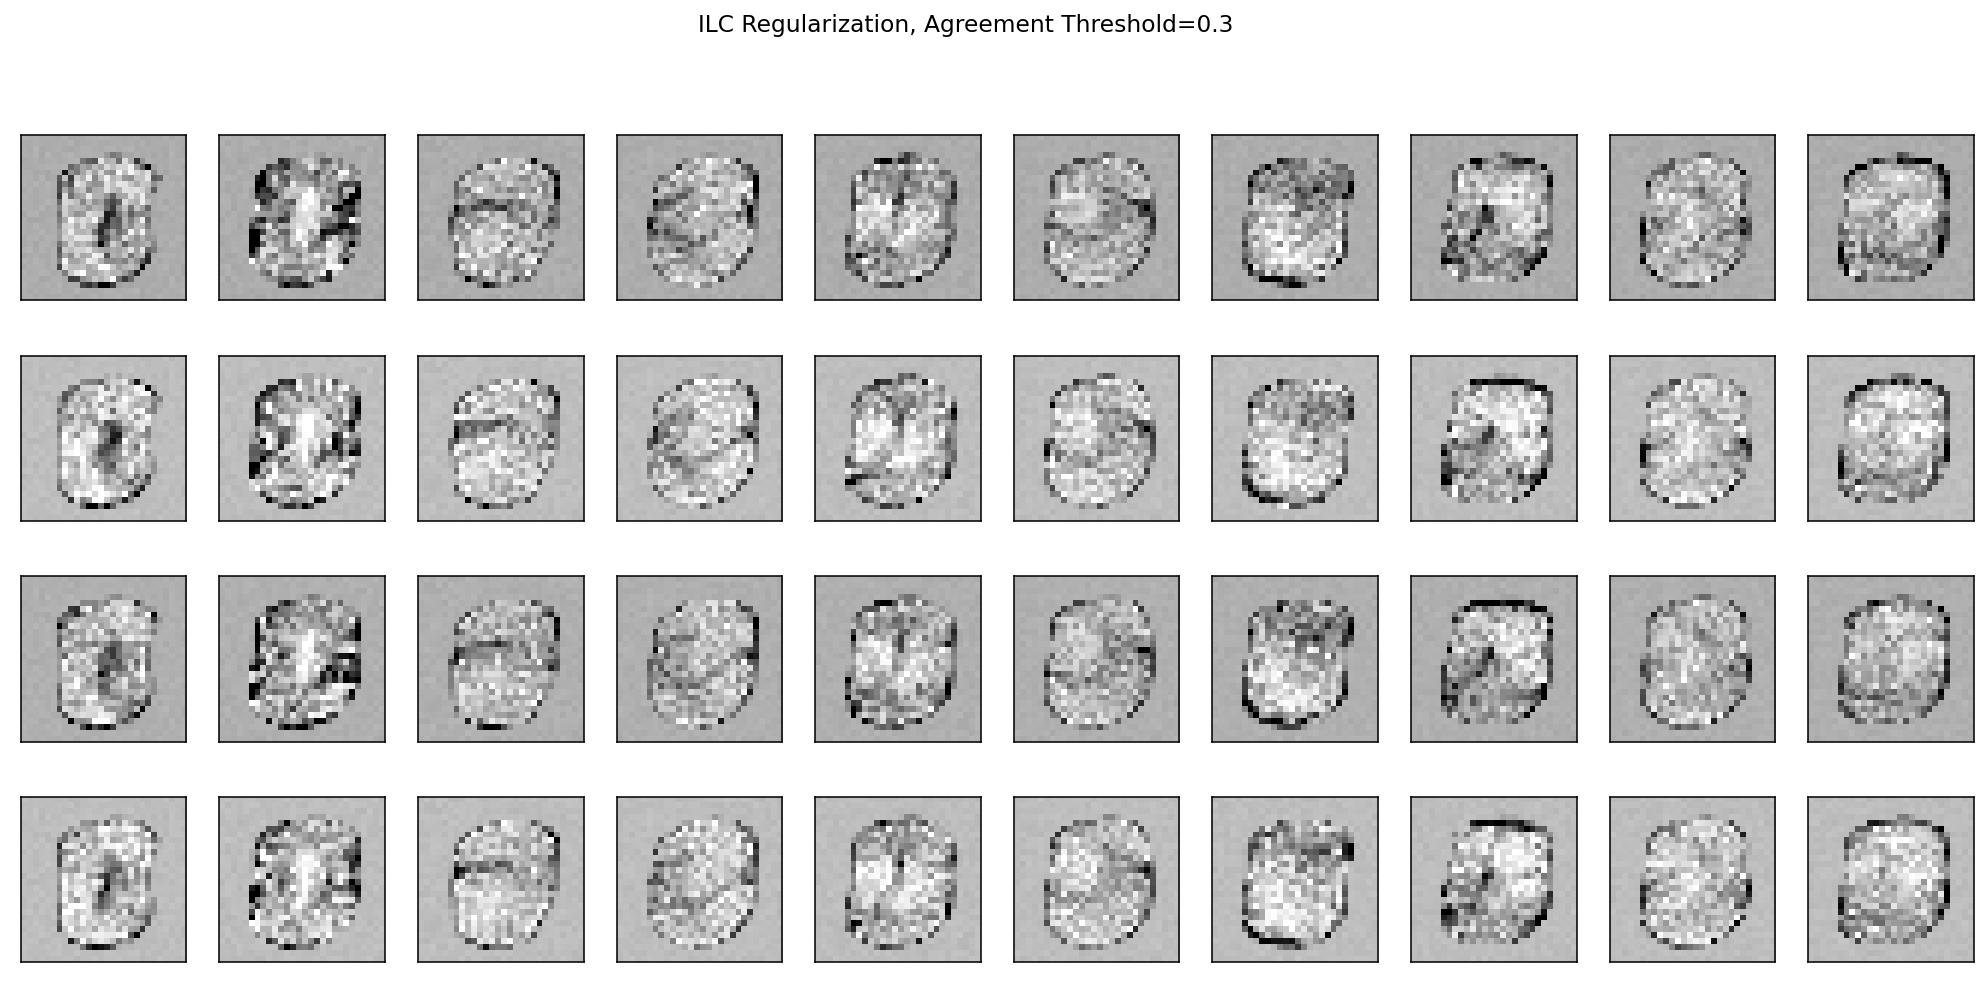

In [138]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

fig, axes = plt.subplots(4, 10, figsize=(18, 8), dpi=140, facecolor='w', edgecolor='k')
# use global min / max to ensure all weights are shown on the same scale
for m in range(n_envs):
    vmin, vmax = envs_ilc_params[m]['linear']['w'].min(), envs_ilc_params[m]['linear']['w'].max()
    for coef, ax in zip(envs_ilc_params[m]['linear']['w'].T, axes[m,:]):
        ax.matshow(coef.reshape(28, 28), cmap=plt.cm.gray, vmin=.5 * vmin,
                vmax=.5 * vmax)
        ax.set_xticks(())
        ax.set_yticks(())

plt.suptitle('ILC Regularization, Agreement Threshold=0.3')
plt.show()

### Agreement Threshold = 0.7

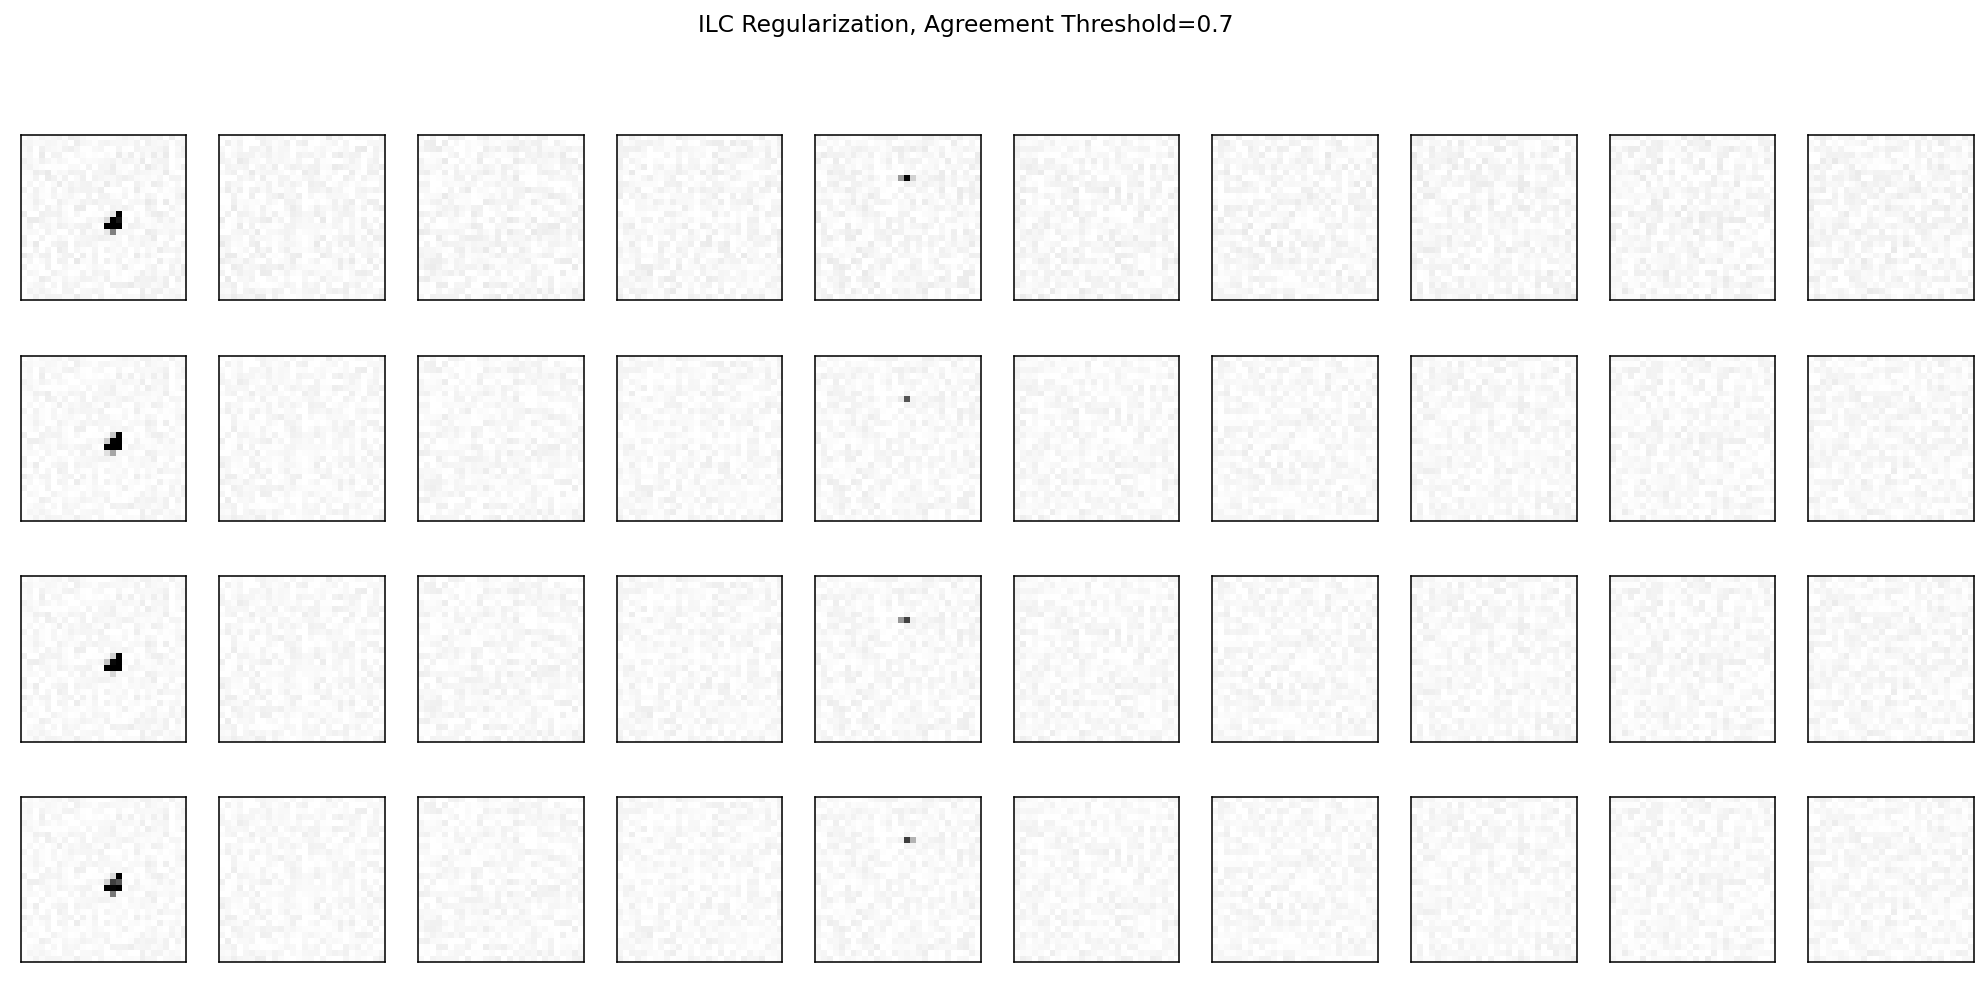

In [140]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

fig, axes = plt.subplots(4, 10, figsize=(18, 8), dpi=140, facecolor='w', edgecolor='k')
# use global min / max to ensure all weights are shown on the same scale
for m in range(n_envs):
    vmin, vmax = envs_ilc_params[m]['linear']['w'].min(), envs_ilc_params[m]['linear']['w'].max()
    for coef, ax in zip(envs_ilc_params[m]['linear']['w'].T, axes[m,:]):
        ax.matshow(coef.reshape(28, 28), cmap=plt.cm.gray, vmin=.5 * vmin,
                vmax=.5 * vmax)
        ax.set_xticks(())
        ax.set_yticks(())

plt.suptitle('ILC Regularization, Agreement Threshold=0.7')
plt.show()

### Agreement Threshold = 0.9

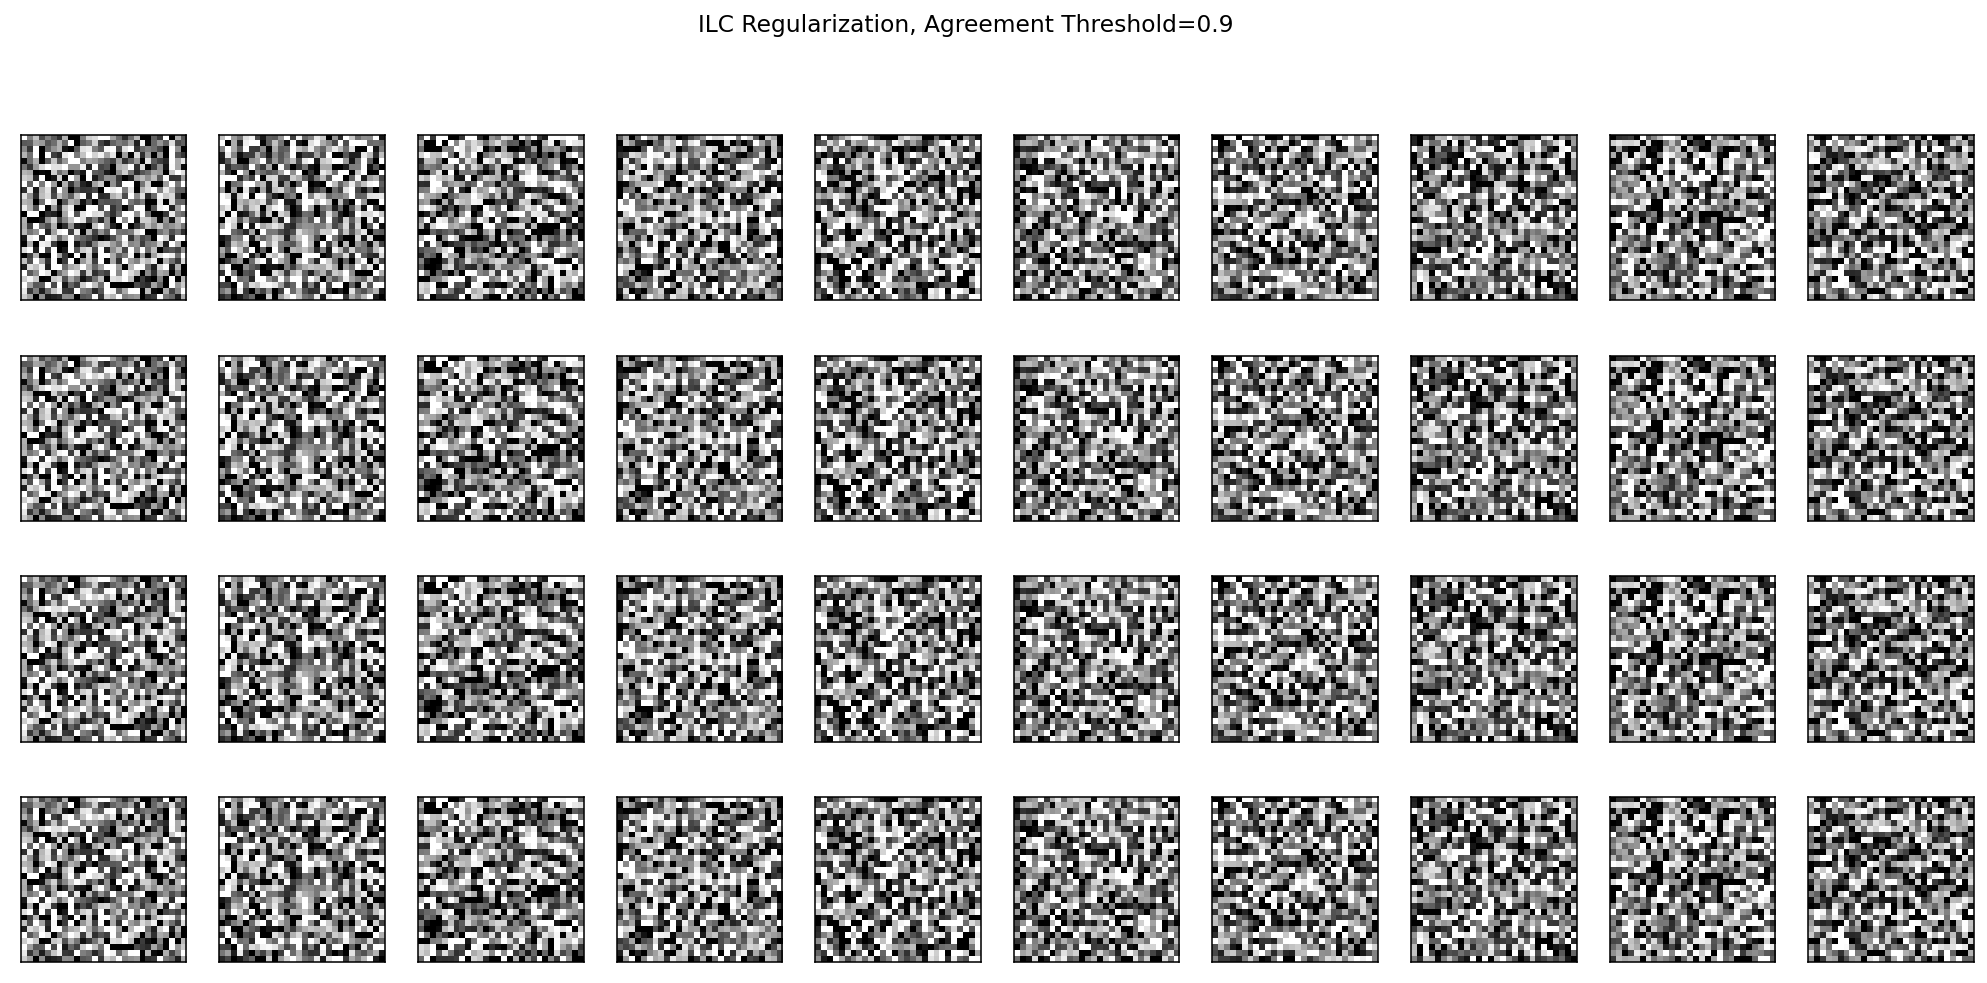

In [142]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

fig, axes = plt.subplots(4, 10, figsize=(18, 8), dpi=140, facecolor='w', edgecolor='k')
# use global min / max to ensure all weights are shown on the same scale
for m in range(n_envs):
    vmin, vmax = envs_ilc_params[m]['linear']['w'].min(), envs_ilc_params[m]['linear']['w'].max()
    for coef, ax in zip(envs_ilc_params[m]['linear']['w'].T, axes[m,:]):
        ax.matshow(coef.reshape(28, 28), cmap=plt.cm.gray, vmin=.5 * vmin,
                vmax=.5 * vmax)
        ax.set_xticks(())
        ax.set_yticks(())

plt.suptitle('ILC Regularization, Agreement Threshold=0.9')
plt.show()

In [98]:
!pip freeze > requirements.txt